In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import median_filter
from PIL import Image
import math
from utils.utils import cluster_flow_time_series, flow_to_features, flow_to_image, create_image_grid, extract_frames, normalize_flow_magnitude, MaybeToTensor, AddSumChannel, Normalize, weighted_dot, expand_by_edges
import torch
import numpy as np
import cv2

### Flow clutering

In [4]:
T, H, W = 91, 224, 224
# Dummy data; replace with your real flow array of shape (T,2,224,224)
# rng = np.random.default_rng(42)
# flow = rng.normal(size=(T, 2, H, W)).astype(np.float32)
flow = np.load("/data2/hongn/RAFT/flows_sample.npy", allow_pickle=True)
n_clusters = 10
labels, clusters, features = cluster_flow_time_series(
    flow, n_clusters,
    num_dir_bins=16, grid=8,
    smooth_window=5,      # try 0 for no smoothing, or an odd number like 3/5/7
    random_state=42
)

print("Labels shape:", labels.shape)          # (T,)
print("Cluster sizes:", [len(c) for c in clusters])

Labels shape: (91,)
Cluster sizes: [7, 8, 16, 8, 9, 8, 5, 7, 8, 15]


In [5]:
clusters = sorted(clusters, key=lambda a: (len(a) == 0, a[0] if a else float('inf')))
clusters

[[0, 1, 2, 3, 4, 5, 6],
 [7, 8, 9, 10, 11, 12, 13, 14],
 [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
 [31, 32, 33, 34, 35, 36, 37, 38],
 [39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55],
 [56, 57, 58, 59, 60],
 [61, 62, 63, 64, 65, 66, 67],
 [68, 69, 70, 71, 72, 73, 74, 75],
 [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]]

In [6]:
int(np.floor(len(clusters[0])/2))

3

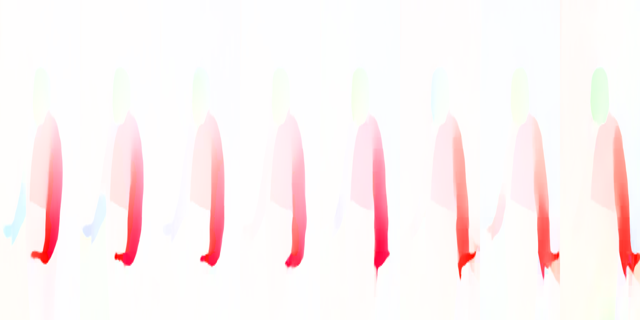

In [7]:
flows_cluster = [flow_to_image(torch.Tensor(f).permute(1, 2, 0).cpu().numpy()) for f in flow[clusters[5]]]
image_grid = create_image_grid(flows_cluster, num_columns=8)
display(image_grid.resize((640, 320)))

### Visual embeddings on key flows

In [8]:
frames_idx = [c[int(np.floor(len(c)/2))] if len(c) > 0 else None for c in clusters]
frames_idx = [x for x in frames_idx if x is not None]
corresponding_flows = [flow[i] for i in frames_idx]
corresponding_flows = np.stack(corresponding_flows)
frames_idx

[3, 11, 23, 35, 43, 52, 58, 64, 72, 83]

In [9]:
clusters

[[0, 1, 2, 3, 4, 5, 6],
 [7, 8, 9, 10, 11, 12, 13, 14],
 [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
 [31, 32, 33, 34, 35, 36, 37, 38],
 [39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55],
 [56, 57, 58, 59, 60],
 [61, 62, 63, 64, 65, 66, 67],
 [68, 69, 70, 71, 72, 73, 74, 75],
 [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]]

In [10]:
video_frames = extract_frames("/data2/hongn/RAFT/seamless_sample.mp4", frames_idx)

In [11]:
video_frames.shape

torch.Size([10, 3840, 2160, 3])

Get embeddings from DINIOv2

In [12]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

inputs = processor(images=video_frames, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state # [Batch, patches + cls tokens, emb length]


In [14]:

inputs['pixel_values'].shape

torch.Size([10, 3, 224, 224])

In [11]:
last_hidden_states.shape

torch.Size([10, 257, 768])

Attention to important patch

In [12]:
norm_mag = normalize_flow_magnitude(torch.Tensor(corresponding_flows), clip_val=0.5)

print(norm_mag.shape)  # torch.Size([4, 16, 16])
print(norm_mag.min().item(), norm_mag.max().item())  # [>=0.05, <=1.0]

torch.Size([10, 16, 16])
0.5 1.0


In [13]:
def weighted_dot(A, B):
    """
    A: [B, 16, 16, 768]
    B: [B, 16, 16]
    Returns: [B, 768]
    """
    # expand B -> [B, 16, 16, 1] for broadcasting
    B_exp = B.unsqueeze(-1)

    # elementwise multiply, then sum over spatial dims
    out = (A * B_exp).sum(dim=(1, 2))  # [B, 768]

    return out

In [14]:
last_hidden_states[:,1:,:].shape

torch.Size([10, 256, 768])

In [15]:
reshape_hidden_states = last_hidden_states[:,1:,:].view(last_hidden_states.size(0), 16, 16, 768)

In [16]:
weighted_image_embeddings = weighted_dot(reshape_hidden_states, norm_mag)
weighted_image_embeddings.shape

torch.Size([10, 768])

### Mamba block

padding visual to same length as motion

In [17]:
flow.shape

(91, 2, 224, 224)

In [18]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch

# img = Image.open(urlopen(
#     'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
# ))

model = timm.create_model('resnet18.a1_in1k', pretrained=True)
model.fc = torch.nn.Identity()
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

# output_embbeddings = model(transforms(flow).unsqueeze(0))  # unsqueeze single image into batch of 1

# top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


In [19]:
transforms

Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [21]:
# ---- build your transform ----
from torch import nn
# Order: to-tensor -> add sum channel -> normalize (3 channels)
flow_transform = nn.Sequential(
    MaybeToTensor(),
    AddSumChannel(),
    Normalize(
        mean=torch.tensor([0.4850, 0.4560, 0.5]),  # third channel left as-is
        std=torch.tensor([0.2290, 0.2240, 0.2]),
    ),
)

# usage:
# x: np.ndarray or torch.Tensor with shape [B, 2, 224, 224]
# y = flow_transform(x)  # -> shape [B, 3, 224, 224]


In [22]:
x = flow_transform(flow)

In [38]:
flow_embeddings = model(x)

Padding visual embeddings

In [ ]:
# x as simple identifiable rows; works the same if rows are 768-dim lists/arrays
print(weighted_image_embeddings.shape)

y = expand_by_edges(weighted_image_embeddings, frames_idx, out_len=len(flow))

# verifies your expectations:
assert all(all(y[j] == weighted_image_embeddings[0]) for j in range(0, frames_idx[0]))     # y[0:10] are x[0]
# assert all(y[j] == weighted_image_embeddings[4] for j in range(61, 100))   # y[61:99] are x[4]
y = torch.stack(y)
y.shape

torch.Size([10, 768])


torch.Size([100, 768])

Padding flows to 100

In [40]:
print(flow_embeddings.shape)
def pad_repeat_last_torch(x: torch.Tensor, out_len: int = 100) -> torch.Tensor:
    # x: [B, 512]
    B, D = x.shape
    if D != 512:
        raise ValueError(f"Expected 512 features, got {D}")
    if B >= out_len:
        return x[:out_len].clone()
    pad = x[-1:].repeat(out_len - B, 1)   # duplicate last row
    return torch.cat([x, pad], dim=0)     # -> [100, 512]


y2 = pad_repeat_last_torch(flow_embeddings)

torch.Size([91, 512])


In [41]:
y2.shape

torch.Size([100, 512])

In [ ]:
import torch
from mamba_ssm import Mamba

batch, length, dim = 17, 64, 16
x = torch.randn(batch, length, dim).to("cuda")
model = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=16,  # SSM state expansion factor
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
).to("cuda")
y = model(x)
assert y.shape == x.shape

### Text embeddings

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

# prepare input
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')

# forward pass
output = model(**encoded_input)
output

/data2/hongn/miniconda3/envs/moose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MaskedLMOutput(loss=None, logits=tensor([[[ 6.4447e+01,  3.2507e-02,  3.7382e+01,  ...,  2.1459e+01,
           1.4222e+01,  1.8874e+01],
         [ 2.7079e+01, -1.3935e+00,  6.4573e+01,  ...,  4.0109e+01,
           1.6137e+01,  3.1009e+01],
         [ 1.9189e+01, -1.2440e+00,  4.8706e+01,  ...,  3.5705e+01,
           1.6987e+01,  2.7256e+01],
         ...,
         [ 2.2506e+01, -1.4501e+00,  5.0936e+01,  ...,  3.8371e+01,
           1.6350e+01,  2.7771e+01],
         [ 2.8184e+01, -1.2711e+00,  6.7431e+01,  ...,  4.4732e+01,
           1.7845e+01,  3.5088e+01],
         [ 4.4540e+01, -1.9992e-01,  4.9368e+01,  ...,  2.8129e+01,
           1.6683e+01,  2.3694e+01]]], grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [ ]:
output.logits.shape

torch.Size([1, 13, 250002])

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/LaBSE')
embeddings = model.encode(sentences)
print(embeddings)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[[ 0.02882477 -0.00602378 -0.05947006 ... -0.0300225  -0.02960699
   0.0006748 ]
 [-0.05550231  0.02546483 -0.02157257 ...  0.02932106  0.01150042
  -0.00848791]]


In [ ]:
len(embeddings[0])

768

In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    # Convert to numpy arrays
    v1 = np.array(vec1, dtype=float)
    v2 = np.array(vec2, dtype=float)
    
    # Match lengths by zero-padding the shorter vector
    max_len = max(len(v1), len(v2))
    if len(v1) < max_len:
        v1 = np.pad(v1, (0, max_len - len(v1)), 'constant')
    if len(v2) < max_len:
        v2 = np.pad(v2, (0, max_len - len(v2)), 'constant')
    print(v1, v2)
    # Compute cosine similarity
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0  # Avoid division by zero
    
    return dot_product / (norm_v1 * norm_v2)

# Example usage
vec_a = [1, 2, 3, 9]
vec_b = [4, 5]
similarity = cosine_similarity(vec_a, vec_b)
print(f"Cosine Similarity: {similarity:.4f}")

[1. 2. 3. 9.] [4. 5. 0. 0.]
Cosine Similarity: 0.2243


### Dataloader TEST

In [1]:
from CAREdataset import SEAMLESSData, pad_time_collate
from torch.utils.data import DataLoader
from model import VideoFlowModel
import torch 
ds = SEAMLESSData("/data1/open_data/seamless_interaction/preprocessed/train/clips.csv", resize=224)  # fixed H,W; variable T
loader = DataLoader(ds, batch_size=3, shuffle=True, num_workers=2,
                    collate_fn=pad_time_collate, pin_memory=True)

for batch in loader:
    vids = batch["video"]       # (B, C, T_max, H, W)
    video_mask = batch["video_mask"]        # (B, T_max) -> useful for attention
    lens = batch["lengths"]     # (B,)
    flows = batch["flows"]       # (B, T_max, 2, H, W)
    frames_idx = batch["frames_idx"]  # (B, T_max) -> indices of frames in the original video
    text = batch["transcript"]  # (B,)
    text_mask = batch["text_mask"]  # (B, T_max) -> useful for attention
    print(vids.shape, lens.tolist())

    vids = vids.cuda()
    flows = flows.cuda()
    video_mask = video_mask.cuda()
    text = text.cuda()
    text_mask = text_mask.cuda()
    model = VideoFlowModel().cuda()

    v_feats, t_feats = model(vids, text) 
    break

/data2/hongn/miniconda3/envs/moose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


torch.Size([3, 32, 3, 224, 224]) [32, 32, 24]


/data2/hongn/miniconda3/envs/moose/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceC

In [5]:
v_feats[:, :1].shape

torch.Size([3, 1, 768])

In [10]:
t_feats.logits.shape

torch.Size([3, 32, 768])

In [2]:
vids.shape

torch.Size([3, 8, 32, 224, 224])

In [3]:
text.shape

torch.Size([3, 32])

In [6]:
print(len(t_feats))
t_feats[0].logits.shape

3


torch.Size([1, 10, 250002])

In [5]:
v_feats.shape

torch.Size([3, 1569, 768])

In [2]:
from model import VideoFlowModel

vids = vids.cuda()
flows = flows.cuda()
mask = mask.cuda()
transcript = torch.stack(transcript).cuda()
model = VideoFlowModel().cuda()

x = model(vids, transcript)  # (B, T_max, D) -> per-frame features

ModuleNotFoundError: No module named 'Optional'

In [2]:
transcript

[tensor([    0,  1401,    25,  1181,   765,    47, 40485,     5,     2]),
 tensor([     0,   9925, 103049,      5,      2]),
 tensor([   0, 3164, 7108,    5,    2])]

In [6]:
transcript

["I'm brushing my long, beautiful hair.",
 "It's round, all right?",
 'The child is scared of the dark, okay?']

In [6]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch.nn as nn
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")
model.lm_head = nn.Identity()  # remove the final layer to get embeddings 
# prepare input
text = transcript[0]
# encoded_input = tokenizer(text, return_tensors='pt')

# forward pass
output = model(transcript[0])


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


IndexError: too many indices for tensor of dimension 1

In [11]:
video_mask.shape

torch.Size([3, 32])

### Training Pipeline

In [1]:
from loss import multimodal_alignment_loss, global_clip_loss
from CAREdataset import SEAMLESSData, pad_time_collate
from torch.utils.data import DataLoader
from model import VideoFlowModel
import torch 
DEVICE = "cuda:2" if torch.cuda.is_available() else "cpu"
ds = SEAMLESSData("/data1/open_data/seamless_interaction/preprocessed/train/clips.csv", resize=224)  # fixed H,W; variable T
loader = DataLoader(ds, batch_size=4, shuffle=True, num_workers=1, collate_fn=pad_time_collate, pin_memory=False)
model = VideoFlowModel().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


for batch in loader:
    vids = batch["video"].to(DEVICE)       # (B, C, T_max, H, W)
    transcript = batch["transcript"].to(DEVICE)                     # (B,)
    v_mask = None               # (B, T1) optional
    t_mask = batch["text_mask"].to(DEVICE)                # (B, T2) optional
    if v_mask is not None: v_mask = v_mask.to(DEVICE)
    if t_mask is not None: t_mask = t_mask.to(DEVICE)
    # break
    v_feats, t_feats = model(vids, transcript)           # v:[B,T1,768], t:[B,T2,768]
    # break
    loss = global_clip_loss(
        v_feats, t_feats, v_mask=v_mask, t_mask=t_mask,
        temperature=0.07
    )

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # (optional) log pieces
    print(f"loss={loss.item():.4f}")


/data2/hongn/miniconda3/envs/moose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.
/data2/hongn/miniconda3/envs/moose/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


loss=1.3973
loss=1.4461
loss=1.3946
loss=1.3963
loss=1.3880
loss=1.4040


KeyboardInterrupt: 

In [2]:
v_feats.device

device(type='cuda', index=2)

In [3]:
t_feats.device

device(type='cuda', index=2)

In [2]:
v_feats.shape

torch.Size([2, 1, 768])

In [3]:
t_feats.shape

torch.Size([2, 32, 768])

In [4]:
v_feats[:, :1].shape

torch.Size([1, 1, 768])

In [5]:
t_mask.shape

torch.Size([1, 32])

In [14]:
print(transcript[0])
output.logits.shape

I'm brushing my long, beautiful hair.


torch.Size([1, 13, 768])

In [11]:
model

XLMRobertaForMaskedLM(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True

In [3]:
flows.shape

torch.Size([3, 2, 100, 224, 224])

In [4]:
flows.shape

torch.Size([3, 2, 100, 224, 224])

In [3]:
batch.keys()

dict_keys(['flows', 'mask', 'lengths', 'video', 'frames_idx', 'transcript', 'path'])

In [ ]:
import pandas as pd
from pathlib import Path
df = pd.read_csv("/data1/open_data/seamless_interaction/preprocessed/train/clips.csv")[:800]

flows_paths = [str(Path(p).with_suffix('.npy')) for p in df["path_to_clip"].astype(str)]

TypeError: can only concatenate list (not "str") to list

In [7]:
from pathlib import Path
flows_paths = [str(Path(p).with_suffix('.npy')) for p in df["path_to_clip"].astype(str)]

In [8]:
flows_paths

['/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_001_00-00-15.437-00-00-16.197_Okay_okay.npy',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_002_00-00-32.761-00-00-34.922_Well_dinner.npy',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_003_00-00-46.127-00-00-49.148_Okay_okay_full_sentence_okay.npy',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_004_00-00-57.511-00-01-08.655_Well_I_was_thinking_maybe_we_go_to_Titos.npy',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_005_00-01-08.836-00-01-10.336_Youre_confused_about_tacos.npy',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V

In [6]:
df["path_to_clip"].astype(str).tolist()

['/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_001_00-00-15.437-00-00-16.197_Okay_okay.mp4',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_002_00-00-32.761-00-00-34.922_Well_dinner.mp4',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_003_00-00-46.127-00-00-49.148_Okay_okay_full_sentence_okay.mp4',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_004_00-00-57.511-00-01-08.655_Well_I_was_thinking_maybe_we_go_to_Titos.mp4',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V00_S0521_I00000497_P0663_005_00-01-08.836-00-01-10.336_Youre_confused_about_tacos.mp4',
 '/data1/open_data/seamless_interaction/preprocessed/train/0000/0001/V00_S0521_I00000497_P0663/V

In [3]:
import av
import numpy as np

from transformers import AutoImageProcessor, TimesformerModel
from huggingface_hub import hf_hub_download

np.random.seed(0)


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`list[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`list[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


# video clip consists of 300 frames (10 seconds at 30 FPS)
file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
container = av.open(file_path)

# sample 8 frames
indices = sample_frame_indices(clip_len=8, frame_sample_rate=4, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400")

# prepare video for the model
inputs = image_processor(list(video), return_tensors="pt")

# forward pass
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

[1, 1569, 768]

In [4]:
inputs['pixel_values'].shape

torch.Size([1, 8, 3, 224, 224])